# Snowml Introduction and Demo

## Snowml 
* Data science toolkit with native Snowflake functionality.
* In database transformers and feature engineering using Snowflake and Snowpark.

In [1]:
# Demo Snowml v1.3, Imports 
#
# Written by 
#   Garrett Frere
# February 2023
#
# Snowpark
#    https://docs.snowflake.com/en/developer-guide/snowpark/python/index.html
# SnowSQL Client
#    https://docs.snowflake.com/en/user-guide/snowsql-install-config.html
# Snowml Wheel File
#    pip3 install 'snowflake_ml_python‑0.2.0‑py3‑none‑any.whl'


# Snowpark Connector, Snowpark Library, Session
import snowflake.connector
import snowflake.snowpark
import snowflake.ml.preprocessing as snowml
from snowflake.snowpark import Session
from snowflake.snowpark.version import VERSION
from snowflake.ml.utils import connection_params
from snowflake.ml.metrics.correlation import correlation


# Pandas Tools
from snowflake.connector.pandas_tools import write_pandas

# Data Science Libs
import numpy as np
import pandas as pd

# create_temp_table warning suppresion
import warnings; warnings.simplefilter('ignore')

### Snowpark Connection

In [2]:
# Make a Snowpark Connection
session = snowflake.snowpark.Session.builder.configs(
    connection_params.SnowflakeLoginOptions(connection_name='connections.snowml')
).create()

print("----------------------------------------")
snowflake_environment = session.sql('select current_warehouse(), current_database(), current_schema(), current_version()').collect()
snowpark_version = VERSION
print('Warehouse                   : {}'.format(snowflake_environment[0][0]))
print('Database                    : {}'.format(snowflake_environment[0][1]))
print('Schema                      : {}'.format(snowflake_environment[0][2]))
print('Snowflake version           : {}'.format(snowflake_environment[0][3]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))
print("----------------------------------------")

----------------------------------------
Warehouse                   : DEMO_SNOWML
Database                    : SNOWML
Schema                      : DEMO
Snowflake version           : 7.6.4
Snowpark for Python version : 1.0.0
----------------------------------------


### Diamonds Data

Diamonds data set has been widely used in data science and machine learning.\
Selected to demonstrate Snowflake native data science transformers in database functionality, Spark and Pands comportablity, using non-synthetic and statistically appropriate data that is well known to the ML community.
* Shape - 10 x 53940
* Raw size - 3.19 MB
* Location - https://github.com/tidyverse/ggplot2/blob/882584f915b23cda5091fb69e88f19e8200811bf/data-raw/diamonds.csv
* For this demo download the Diamonds csv data set using the link above, using code cell below write it to a Snowflake table.


In [3]:
# Define the Table and Cleanup Cols, have a work_schema for testing
work_schema = 'DEMO'
demo_table = 'DIAMONDS'

# Read csv of diamonds data to a dataframe, set data_dir to path of your csv download
data_dir = '/csv/download/path/'
file = 'diamonds.csv'
df = pd.read_csv(data_dir+file)

# Cleanup - remove row column and force headers to Uppercase
df.columns = df.columns.str.upper()

# write the DF to Snowflake and create a Snowflake DF
session.write_pandas(df, demo_table, auto_create_table=True, create_temp_table=True, schema=work_schema)

### Snowflake Dataframe

In [34]:
# Diamonds Snowflake Table
input_tbl = f"{session.get_current_database()}.{session.get_current_schema()}.{demo_table}"
diamonds_df = session.table(input_tbl).drop('ROW')
diamonds_df.limit(10).to_pandas()

,CARAT,CUT,COLOR,CLARITY,DEPTH,TABLE,PRICE,X,Y,Z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


### Min Max Scaler

Snowml MinMaxScaler is used to normalize CARAT. 

*  Establishes each observations carat size relative to the data set.
*  Provides meaning to the variable if you are unfamiliar diamond carats.

In [27]:
# Normalize the CARAT column
target_cols = ['CARAT']
target_cols_out = ['CARAT_NORM']
snowml_mms = snowml.MinMaxScaler(input_cols=target_cols, output_cols=target_cols_out)
snowml_mms.fit(diamonds_df)
normalized_diamonds_df = snowml_mms.transform(diamonds_df)
from snowflake.snowpark.types import DecimalType
new_col = normalized_diamonds_df.col('CARAT_NORM').cast(DecimalType(7, 6))
normalized_diamonds_df = normalized_diamonds_df.with_column('CARAT_NORM', new_col)
normalized_diamonds_df.limit(10).to_pandas()

,CARAT,CUT,COLOR,CLARITY,DEPTH,TABLE,PRICE,X,Y,Z,CARAT_NORM
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0.006237
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,0.002079
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,0.006237
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,0.018711
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,0.022869
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48,0.008316
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47,0.008316
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53,0.012474
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49,0.004158
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39,0.006237


### Ordinal Encoder

Snowml OrdinalEncoder transforms CUT and CLARITY from categorical to numerical values. 

*  Ordinal importance is maintained.
*  Numerical encoding can be used in arithmetic operations.

In [26]:
# Encode CUT and CLARITY preserve Ordinal importance
target_cols = ["CUT", "CLARITY"]
target_cols_out = ["CUT_OE", "CLARITY_OE"]
snowml_oe = snowml.OrdinalEncoder(input_cols=target_cols, output_cols=target_cols_out)
snowml_oe.fit(normalized_diamonds_df)
ord_encoded_diamonds_df = snowml_oe.transform(normalized_diamonds_df)

# Show encoded CUT and CLARITY
ord_encoded_diamonds_df.limit(10).to_pandas()

,CARAT,CUT,COLOR,CLARITY,DEPTH,TABLE,PRICE,X,Y,Z,CARAT_NORM,CUT_OE,CLARITY_OE
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,0.006237,2.0,3.0
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,0.002079,3.0,2.0
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,0.006237,1.0,4.0
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,0.018711,3.0,5.0
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,0.022869,1.0,3.0
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48,0.008316,4.0,7.0
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47,0.008316,4.0,6.0
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53,0.012474,4.0,2.0
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49,0.004158,0.0,5.0
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39,0.006237,4.0,4.0


### One-hot Encoder

Snowml OneHotEncoder transforms COLOR from categorical to numerical values. 

*  Does not enforce ordinal importance.
*  Numerical encoding can be used in arithmetic operations.

In [25]:
# Encode COLOR categorical to numeric columns
target_cols = ["COLOR"]
target_cols_out = ["COLOR_OHE"]
snowml_ohe = snowml.OneHotEncoder(input_cols=target_cols, output_cols=target_cols_out)
snowml_ohe.fit(ord_encoded_diamonds_df)
transformed_diamonds_df = snowml_ohe.transform(ord_encoded_diamonds_df)
transformed_diamonds_df.columns

['CARAT',
 'CUT',
 'COLOR',
 'CLARITY',
 'DEPTH',
 'TABLE',
 'PRICE',
 'X',
 'Y',
 'Z',
 'CARAT_NORM',
 'CUT_OE',
 'CLARITY_OE',
 '"COLOR_OHE_\'D\'"',
 '"COLOR_OHE_\'E\'"',
 '"COLOR_OHE_\'F\'"',
 '"COLOR_OHE_\'G\'"',
 '"COLOR_OHE_\'H\'"',
 '"COLOR_OHE_\'I\'"',
 '"COLOR_OHE_\'J\'"']

### Pearson Correlation

Snowml Correlation will estimate the linear relationship of all combinations of numerical features and produce symetrical 
output.

Correlation is normalized Covariance from 1 to -1.
* Coefficeint of  1 indicates perfect linear relationship.
* Coefficeint of  0 indicates no linear relationship.
* Coefficeint of -1 indicates perfect inverse linear relatinoship. 

In [29]:
# Snowml Pearson Correlation return is Pandas DF
corr_diamonds_df = correlation(df=transformed_diamonds_df)
corr_diamonds_df

,CARAT,DEPTH,TABLE,PRICE,X,Y,Z,CARAT_NORM,CUT_OE,CLARITY_OE,"""COLOR_OHE_'D'""","""COLOR_OHE_'E'""","""COLOR_OHE_'F'""","""COLOR_OHE_'G'""","""COLOR_OHE_'H'""","""COLOR_OHE_'I'""","""COLOR_OHE_'J'"""
CARAT,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387,1.000000,0.017124,-0.214290,-0.112057,-0.139215,-0.060052,-0.029038,0.102465,0.161494,0.180054
DEPTH,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924,0.028224,-0.194249,-0.053080,-0.013566,-0.028713,-0.017741,0.002768,0.026037,0.022630,0.022543
TABLE,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929,0.181618,0.150327,-0.088223,-0.008921,0.007172,-0.004906,-0.038815,0.011574,0.017967,0.037253
PRICE,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249,0.921591,0.039860,-0.071535,-0.072473,-0.101089,-0.024161,0.008556,0.059223,0.097125,0.081710
X,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772,0.975094,0.022342,-0.225721,-0.106127,-0.134213,-0.048021,-0.024593,0.095896,0.146522,0.164658
Y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006,0.951722,0.027572,-0.217616,-0.103999,-0.130136,-0.046707,-0.024479,0.093480,0.142895,0.160776
Z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000,0.953387,0.002037,-0.224263,-0.105216,-0.132210,-0.048803,-0.024582,0.095041,0.145276,0.164217
CARAT_NORM,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387,1.000000,0.017124,-0.214290,-0.112057,-0.139215,-0.060052,-0.029038,0.102465,0.161494,0.180054
CUT_OE,0.017124,-0.194249,0.150327,0.039860,0.022342,0.027572,0.002037,0.017124,1.000000,0.028235,-0.005748,0.015826,-0.007127,-0.009822,0.005391,-0.002063,0.005373
CLARITY_OE,-0.214290,-0.053080,-0.088223,-0.071535,-0.225721,-0.217616,-0.224263,-0.214290,0.028235,1.000000,-0.030691,0.025737,0.016030,0.063217,-0.049210,-0.024639,-0.028895


In [30]:
#  Isolating bivariates that are highly correlated
melted_corr = corr_diamonds_df.abs().unstack()
melted_corr.sort_values(ascending=True, inplace=True)
print("Bivariates that are highly correlated are as follows:")
columns_above_80 = [(col1, col2) for col1, col2 in melted_corr.index if (melted_corr[col1,col2] > 0.8 and col1 != col2)]
results = list(set(map(tuple,map(sorted,columns_above_80))))
for x in results:
    print(x)

Bivariates that are highly correlated are as follows:
('X', 'Y')
('CARAT', 'Y')
('CARAT_NORM', 'Z')
('PRICE', 'Z')
('CARAT_NORM', 'Y')
('CARAT', 'X')
('CARAT_NORM', 'PRICE')
('CARAT', 'CARAT_NORM')
('PRICE', 'Y')
('PRICE', 'X')
('CARAT_NORM', 'X')
('X', 'Z')
('CARAT', 'Z')
('Y', 'Z')
('CARAT', 'PRICE')


#### Correlation results

We find CARAT and it's normalization is the only highly correlated variable to PRICE our target for this data set.\
Let's use a heatmap below to look at all bivariate correlations from the entire feature set.

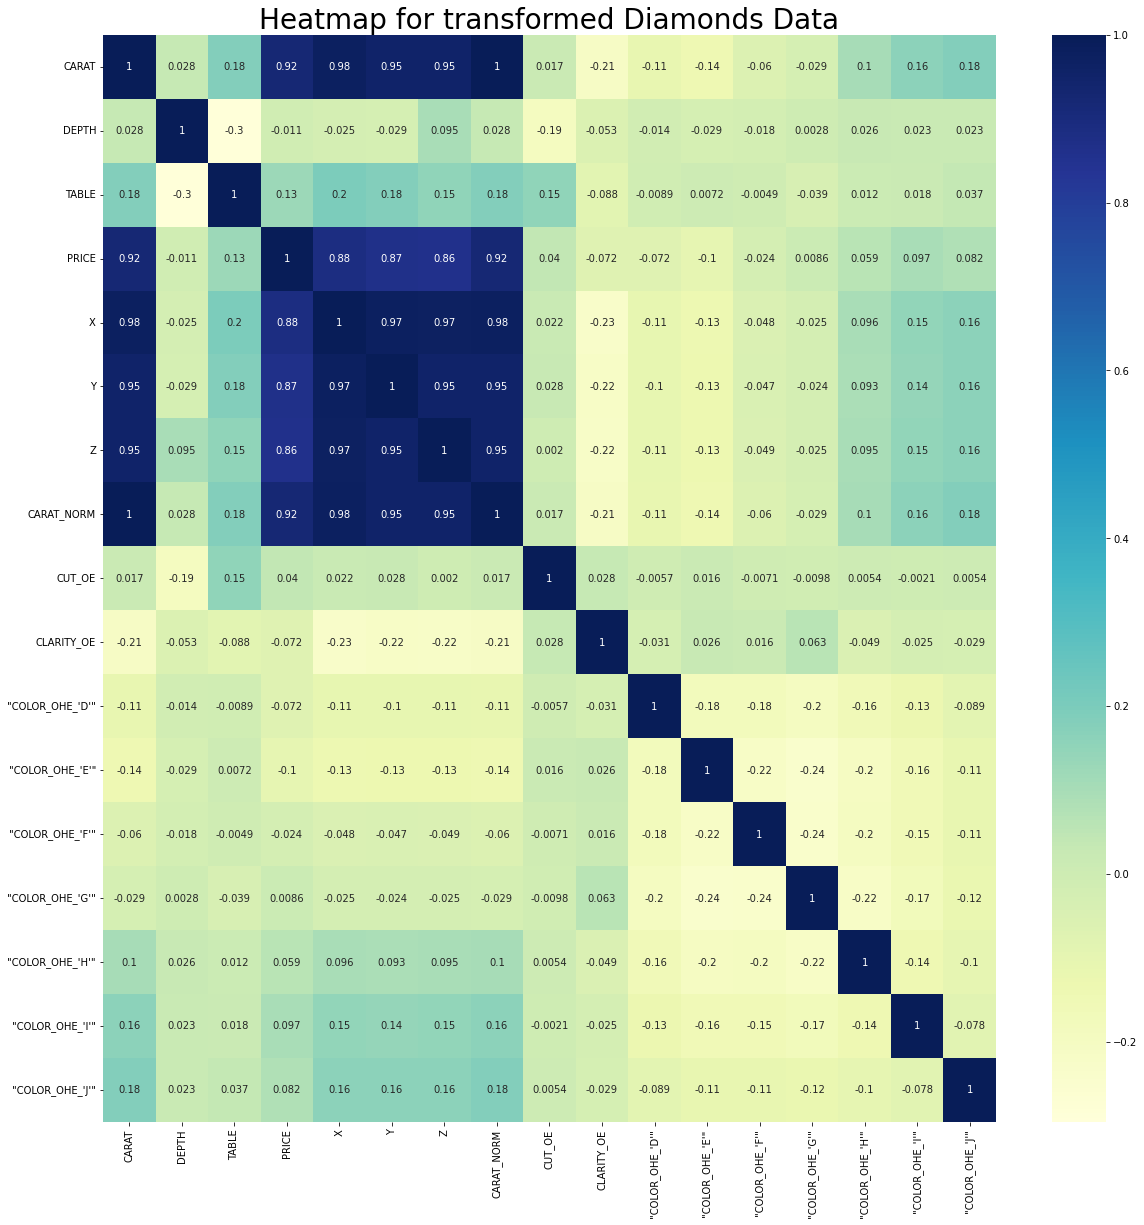

In [31]:
# import heatmap tools
import matplotlib.pyplot as mp
import seaborn as sb

#specify size of heatmap
fig, ax = mp.subplots(figsize=(20, 20))
mp.title('Heatmap for transformed Diamonds Data', fontsize=28)
dataplot = sb.heatmap(corr_diamonds_df, cmap="YlGnBu", annot=True)

# displaying heatmap
mp.show()

##### Relationship CARAT and PRICE

We see there are bands of occurences of specific carat size we believe are commericially common. We also notice the relationship between x, y is not linear.

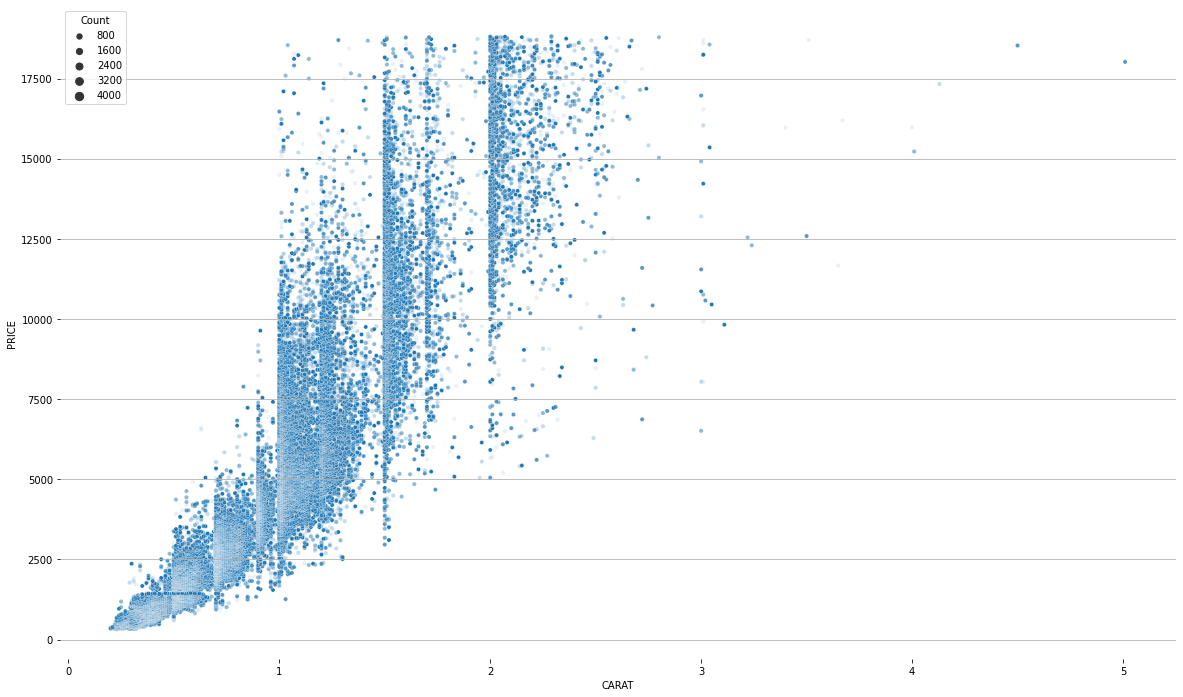

In [32]:
# Setup a plot to look at CARAT and Price
counts = transformed_diamonds_df.to_pandas().groupby(['PRICE', 'CARAT']).size().reset_index(name='Count')

fig, ax = mp.subplots(figsize=(20, 12))
ax = sb.scatterplot(data=counts, x='CARAT', y='PRICE', size='Count', markers='o', alpha=(0.1, .25, 0.5, 0.75, 1))
ax.grid(axis='y')

# The relationship is not linear, it appears exponential which makes sense given the rarity of the large diamonds
sb.move_legend(ax, "upper left")
sb.despine(left=True, bottom=True)